# Analysing chemical data from bills of materials
Use this notebook to explain what SnyOracle is and does in a specific ordered fashion

In [1]:
%colors nocolor

In [2]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import seaborn as sns

try:
    from synoracle import ingredients
except ModuleNotFoundError:
    module_path = os.path.abspath(os.path.join('..'))
    if module_path not in sys.path:
        sys.path.append(module_path)
    from synoracle import ingredients

from tqdm.notebook import tqdm, trange

def li_iterate(li):
    l = iter(li)
    for _ in trange(len(li)):
        yield next(l)

In [3]:
with open('./processed_boms.json', 'r', encoding='utf-8') as f:
    rawdata = json.loads(f.read())

In [4]:
alldata = pd.DataFrame(columns=['pubchem_id','name', 'moles', 'synthesis_number'])
print(alldata)
for k,v in rawdata.items():
    placeholder = pd.DataFrame(eval(v)).reset_index().rename(columns={'index': 'pubchem_id'})
    placeholder['synthesis_number']=int(k)
    alldata = alldata.append(placeholder)

alldata['pubchem_id'] = alldata['pubchem_id'].astype(int)
display(alldata.head())

Empty DataFrame
Columns: [pubchem_id, name, moles, synthesis_number]
Index: []


,pubchem_id,name,moles,synthesis_number
0,702,[ethanol],0.000000,0
1,947,[nitrogen],0.000000,0
2,962,[H2O],1.101671,0
3,12749,[2-methylimidazole],0.002000,0
4,24821,[Co(NO3)2·6H2O],0.000500,0


In [5]:
def contains_element(pubchem_id: int, element_symbol: str) -> bool:
    entity = ingredients.ChemicalSpecies(alias=int(pubchem_id), property_cache_location='./cached_molecule_info.json')
    return element_symbol in entity.mol_formula

def substructure_compare(query_id, compare_id):
    from rdkit import Chem
    compare = ingredients.ChemicalSpecies(alias=int(compare_id), property_cache_location='./cached_molecule_info.json')
    query = ingredients.ChemicalSpecies(alias=int(query_id), property_cache_location='./cached_molecule_info.json')

    compare_chem = Chem.MolFromSmiles(compare.smiles)
    query_chem = Chem.MolFromSmiles(query.smiles)
    return query_chem.HasSubstructMatch(compare_chem)    

def contains_imidazole(pubchem_id: int) -> bool:
    return substructure_compare(pubchem_id, 795)

useful_ions = {
    'nitrate': 943,
    'sulfate': 1117,
    'acetate': 175,
    'chloride': 312,
    'oxide': 190217
}


In [6]:
with open('./chemical_typing_crossreference.json', 'r') as f:
    crossref = pd.DataFrame(json.load(f))
crossref.index = crossref.index.astype(int)

In [7]:
indices = list(alldata['pubchem_id'].unique())
for x in li_iterate(indices):
    try:
        if np.isnan(crossref.loc[x, 'contains_zinc']):
            print(x)
            for k,v in useful_ions.items():
                crossref.loc[x, f'contains_{k}'] = substructure_compare(x, v)
            crossref.loc[x, 'contains_imidazole'] = contains_imidazole(x)
            crossref.loc[x, 'contains_zinc'] = contains_element(x, 'Zn')
            crossref.loc[x, 'contains_cobalt'] = contains_element(x, 'Co')
    except KeyError:
        print(x)
        for k,v in useful_ions.items():
            crossref.loc[x, f'contains_{k}'] = substructure_compare(x, v)
        crossref.loc[x, 'contains_imidazole'] = contains_imidazole(x)
        crossref.loc[x, 'contains_zinc'] = contains_element(x, 'Zn')
        crossref.loc[x, 'contains_cobalt'] = contains_element(x, 'Co')

acids = [311, 313,612,944,  176, 243, 1004,1118, 1133,1152, 14917, 284, 
        1004, 6209, 6347, 7470, 7489, 8496, 11138, 25516, 25517, 
        71370, 517327, 3720192, 6097028]
bases = [1049,1146,129760994, 14797, 14798, 168937, 20586,
         222, 223,23675242, 24243, 243, 24436, 24540, 24654,3301, 5962,
        6115, 6224, 6341, 6503, 7497, 7504, 7618, 7852, 8007, 8102, 
        8111, 8471, 9033, 9237, 9321, 10005, 11107, 14923, 20586,
        24540, 168937, 517045, 2723810,23675242, 129760994 ]
amphoteric = [23663617, 283,943,961,1176, 14013]
surfactants = [5974, 8154, 14253, 2735067, 3423265, 5356789,
              5364713]
solvent_maps = [887, 962, 702, 6228, 6212, 1140, 174, 8028, 679, 8007, 6344, 8058, 3776, 5125, 12051]


crossref['contains_acid'] = crossref.index.isin([x for x in acids])
crossref['contains_base'] = crossref.index.isin([x for x in bases])
crossref['contains_amphoteric'] = crossref.index.isin([x for x in amphoteric])
crossref['contains_surfactant'] = crossref.index.isin([x for x in surfactants])
crossref['contains_solvent'] = crossref.index.isin([x for x in solvent_maps])


  0%|          | 0/407 [00:00<?, ?it/s]

In [8]:
crossref.head()

,contains_imidazole,contains_nitrate,contains_sulfate,contains_acetate,contains_chloride,contains_oxide,contains_zinc,contains_cobalt,contains_acid,contains_base,contains_amphoteric,contains_surfactant,contains_solvent
702,False,False,False,False,False,False,False,False,False,False,False,False,True
947,False,False,False,False,False,False,False,False,False,False,False,False,False
962,False,False,False,False,False,False,False,False,False,False,False,False,True
12749,True,False,False,False,False,False,False,False,False,False,False,False,False
24821,False,True,False,False,False,False,False,True,False,False,False,False,False


In [9]:
crossref.to_json('./chemical_typing_crossreference.json')

In [10]:

alldata = pd.merge(alldata, crossref, left_on='pubchem_id', right_index=True)

In [11]:
by_chemicals = alldata.groupby('pubchem_id').aggregate({
    'name': sum, 
    'moles': max,
    'synthesis_number': lambda x: len(list(x)),
    'contains_imidazole': np.all,
    'contains_zinc': np.all,
    'contains_nitrate': np.all,
    'contains_sulfate': np.all,
    'contains_acetate': np.all,
    'contains_chloride': np.all,
    'contains_oxide': np.all,
    'contains_cobalt': np.all

}).sort_values(by='synthesis_number', ascending=False)

## Solvent statistics

,pubchem_id,synthesis_number
0,887,1053
1,962,643
2,702,431
3,6228,204
4,6212,23
5,1140,16
6,174,14


c:\Users\d23895jm\Anaconda3\envs\SynOracle\lib\site-packages\ipykernel_launcher.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator


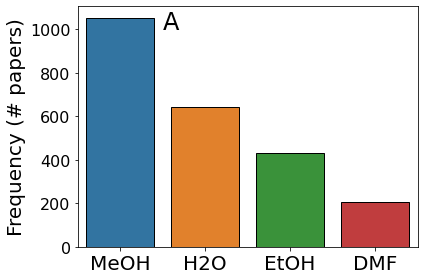

In [19]:
solvent_maps = [887, 962, 702, 6228, 6212, 1140, 174, 8028, 679, 8007, 6344, 8058, 3776, 5125, 12051,]

fig, ax = plt.subplots()


display(by_chemicals[by_chemicals.index.isin([887, 962, 702, 6228, 6212, 1140, 174])]['synthesis_number'].reset_index())#.apply({'pubchem_id': lambda x: x, 'synthesis_number': lambda x: x/1597}))
sns.barplot(
    data = by_chemicals[by_chemicals.index.isin([887, 962, 702, 6228])]['synthesis_number'].reset_index(),
    x = 'pubchem_id',
    y = 'synthesis_number',
    ax=ax, 
    order=[887, 962, 702, 6228],
    edgecolor='k',
    linewidth=1,
    alpha=1
)

xticklabels = ['MeOH', 'H2O', 'EtOH', 'DMF']
ax.set_xticklabels(xticklabels, rotation=0, fontsize=20)
ax.set_yticklabels([int(x) for x in ax.get_yticks()], fontsize=16)


ax.set_xlabel('')
ax.set_ylabel('Frequency (# papers)', fontsize=20)


ax.annotate('A',(0.5, 1000), fontsize=24)

plt.tight_layout()
plt.savefig('Fig 4a.png', dpi=900)

## Quantity analysis
Let's start by making a fresh dataframe to analyse

In [13]:
quant_analysis = alldata.sort_values('synthesis_number').reset_index()

In [14]:
zinc_quants = quant_analysis[(quant_analysis['contains_zinc']) & (quant_analysis['moles']>0)]
cobalt_quants = quant_analysis[(quant_analysis['contains_cobalt']) & (quant_analysis['moles']>0)]
imidazole_quants = quant_analysis[quant_analysis['contains_imidazole']]
imidazole_ratio = imidazole_quants[['synthesis_number', 'moles']].rename({'moles': 'imidazole_moles'}, axis=1)

mixed_metals = pd.concat({'zinc': zinc_quants, 'cobalt': cobalt_quants}).reset_index().sort_values(by='synthesis_number', ascending=False)


In [15]:
stoichiometric_ratio = pd.merge(imidazole_ratio, mixed_metals.rename({
    'moles': 'metal_moles',
    'level_0': 'metal_type'
}, axis=1), on='synthesis_number')

In [16]:
solvent_ratio = quant_analysis[quant_analysis['pubchem_id'].isin(solvent_maps)][['pubchem_id', 'moles', 'synthesis_number']]
solvent_ratio = solvent_ratio.rename({'pubchem_id': 'solvent_pubchem_id', 'moles': 'solvent_moles'}, axis = 1)
solvent_stoichiometry = pd.merge(stoichiometric_ratio, solvent_ratio, on='synthesis_number')
solvent_stoichiometry


,synthesis_number,imidazole_moles,metal_type,level_1,index,pubchem_id,name,metal_moles,contains_imidazole,contains_nitrate,...,contains_oxide,contains_zinc,contains_cobalt,contains_acid,contains_base,contains_amphoteric,contains_surfactant,contains_solvent,solvent_pubchem_id,solvent_moles
0,0,0.002000,cobalt,1,4,24821,[Co(NO3)2·6H2O],0.000500,False,True,...,False,False,True,False,False,False,False,False,702,0.000000
1,0,0.002000,cobalt,1,4,24821,[Co(NO3)2·6H2O],0.000500,False,True,...,False,False,True,False,False,False,False,False,962,1.101671
2,1,0.000000,cobalt,7,3,24821,[Co(NO3)2·6H2O],0.002254,False,True,...,False,False,True,False,False,False,False,False,887,2.313388
3,2,0.000000,zinc,13,3,15865313,[Zn(NO3)2·6H2O],0.000202,False,True,...,False,True,False,False,False,False,False,False,887,0.514086
4,2,0.001583,zinc,13,3,15865313,[Zn(NO3)2·6H2O],0.000202,False,True,...,False,True,False,False,False,False,False,False,887,0.514086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2899,1597,0.007503,zinc,7967,5,15865313,[Zn(NO3)2·6H2O],0.001876,False,True,...,False,True,False,False,False,False,False,False,887,1.028173
2900,1599,0.000000,zinc,7975,4,15865313,"[Zn(NO3)2·6H2O, zinc nitrate hexahydrate]",0.007892,False,True,...,False,True,False,False,False,False,False,False,887,2.056345
2901,1599,0.000000,zinc,7975,4,15865313,"[Zn(NO3)2·6H2O, zinc nitrate hexahydrate]",0.007892,False,True,...,False,True,False,False,False,False,False,False,702,0.000000
2902,1599,0.063203,zinc,7975,4,15865313,"[Zn(NO3)2·6H2O, zinc nitrate hexahydrate]",0.007892,False,True,...,False,True,False,False,False,False,False,False,887,2.056345


0.122 +/- 0.687


c:\Users\d23895jm\Anaconda3\envs\SynOracle\lib\site-packages\ipykernel_launcher.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator


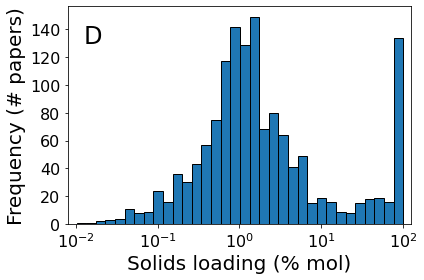

In [20]:
from scipy.stats import norm

solids_loading = pd.merge(
 alldata.groupby('synthesis_number').aggregate('sum')['moles'], 
 solvent_ratio.groupby('synthesis_number').aggregate('sum'),
          left_index=True, right_index=True)
solids_loading['loading'] = 100*(solids_loading['moles'] - solids_loading['solvent_moles'])/solids_loading['moles']
solids_loading['logloading'] = solids_loading['loading'].apply(np.log10)

mu, std = norm.fit(solids_loading[(solids_loading['loading']>0) & (solids_loading['loading']<100)]['logloading'])
print(f'{mu:.3f} +/- {std:.3f}')

xvals = np.linspace(-2,2,100)
yvals = norm.pdf(xvals, mu, std)

fig, ax = plt.subplots()
sns.histplot(
    data = solids_loading[solids_loading['loading']>0],
    x='logloading',
    bins=50, 
    #log_scale=True, 
    ax=ax,
    edgecolor='k',
    linewidth=1,
    alpha=1
 )

#sns.lineplot(x=xvals, y = 150*yvals)


ax.set_xlim([-2.1,2.1])
ax.set_yticklabels([int(x) for x in ax.get_yticks()], fontsize=16)
ax.set_xticks([-2.,-1.,0.,1.,2.])
ax.set_xticklabels(['$10^{-2}$', '$10^{-1}$', '$10^{0}$', '$10^{1}$', '$10^{2}$'], fontsize=16)
ax.set_ylabel('Frequency (# papers)', fontsize=20)
ax.set_xlabel('Solids loading (% mol)', fontsize=20)
ax.annotate('D', (-1.9, 130), fontsize=24)

plt.tight_layout()
plt.savefig('Fig 4d.png', dpi=900)